## Network validation
This scripts is meant to validate that the designed vertex location match the real locations.

The theoratical vertices are found in a network model as net.vertices.
The real vertices are retrieved from a picture of the network suspended in a frame. The following steps are required to enable the comparison:
- Conventional cameras have some distortion. (straight lines appear to be curved). The camera distortion can be found from a set of images of a checkerboard with known dimensions. The image is then undistorted.
- Ideally, a picture of the network is taken exaclty orthogonal to the subject. The homography of the camera angle with respect to the frame is determined. The frame contains markers on a straight plane with known world coordinates. With the homography known an image can be warped such that it appears to take the frame exactly orthogonal to the frame.

Finally, the vertices are selected in the image and they can be compared to their theoratical locations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from src.network import Network_custom

### Open the network model

In [3]:
BYU_UW_root = r"G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Research Projects\Spiders\BYU-UW"
model_name  = 'Validation_structure_1'
net = Network_custom.load_network(os.path.join(BYU_UW_root, 'networks', model_name + '_net.pkl'))

net.net_plot(color=True, elables = True, vlabels = False)

### Load a set of images of checker boards
Internal camera and distortion parameters are determined of the camera. The process needs to be repeated when changing anything on the camera set up (lens/zoom/aperture/etc..). Make sure that auto-focus is off

Camera matrix:
 [[3.09473475e+03 0.00000000e+00 1.54226693e+03]
 [0.00000000e+00 3.08609475e+03 1.99357855e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[ 0.26708744 -1.39979314  0.00452838  0.00322974  2.26933337]]
Mean reprojection error: 0.10328747476442024


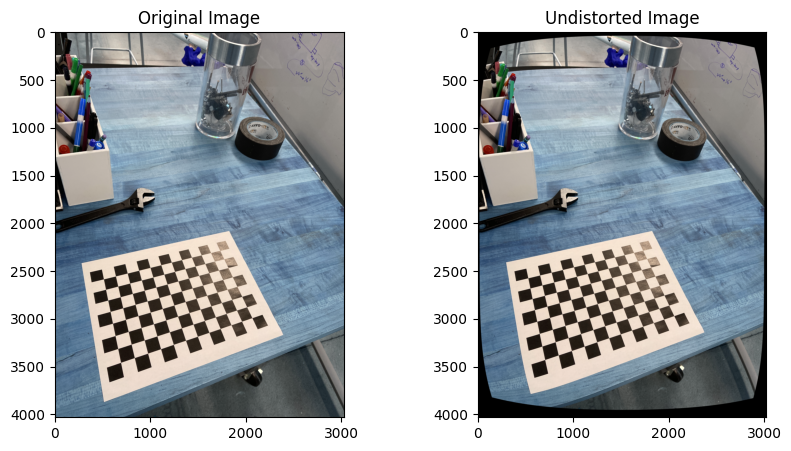

In [4]:
checkerboard_size = (8, 12)  # Number of inner corners per a chessboard row and column
square_size = 6.85/(checkerboard_size[0]+1) * 0.0254

# Termination criteria for corner sub-pixel accuracy
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points based on the real-world dimensions of the checkerboard
objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[1], 0:checkerboard_size[0]].T.reshape(-1, 2)
objp *= square_size

# Arrays to store object points and image points from all the images
objpoints = []  # 3d points in real-world space
imgpoints = []  # 2d points in image plane

# Load images
images = glob.glob(os.path.join(BYU_UW_root,'Calibration images/*.jpg' ))

for fname in images:
    img = cv2.imread(fname)
    img_shape = img.shape[:2]
    img_aspect_ratio = img_shape[1] / img_shape[0]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners( 
                    gray, (12,8),  
                    cv2.CALIB_CB_ADAPTIVE_THRESH  
                    + cv2.CALIB_CB_FAST_CHECK + 
                    cv2.CALIB_CB_NORMALIZE_IMAGE) 
    # If found, add object points, image points (after refining them)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, checkerboard_size, corners2, ret)
        resized_image = cv2.resize(img, (800, int(800 / img_aspect_ratio)))
        cv2.imshow('img', resized_image)
        cv2.waitKey(1)
        
cv2.destroyAllWindows()

# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# Print the camera matrix and distortion coefficients
print("Camera matrix:\n", mtx)
print("Distortion coefficients:\n", dist)

# Check calibration results. A good mean projection error is <1.0
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error
print("Mean reprojection error:", mean_error / len(objpoints))

img = cv2.imread(images[-1])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(cv2.undistort(img, mtx, dist))
ax[1].set_title('Undistorted Image')
plt.show()


### Load an image of the frame and click on the markers

In [5]:
%matplotlib qt
# image_name = "Sample_image_frame_calibration.png"
image_name = model_name + "_pic0.jpg"

image = plt.imread(os.path.join(BYU_UW_root,'measuerement images', image_name))
height, width, _ = image.shape

# image = cv2.undistort(image, mtx, dist)

# Initialize a list to store clicked points
points = []

def on_click(event):
    """Callback function to capture mouse clicks."""
    if event.button == 1:  # Left mouse button
        points.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, 'r.', label='real vertices')
        ax.figure.canvas.draw()

def on_close(event):
    """Callback function to stop the event loop when the figure is closed."""
    plt.close()

# Display the image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(image)
ax.axis('off')  # Hide the axis

# Connect the click and close events
fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('close_event', on_close)

# Start the interactive session
plt.show()

Use this points if you don't want to reassign the points everytime you run the script

In [6]:
# "Sample_image_frame_calibration.png"
# points = np.array([[ 663.99333333,  154.77333333],
#        [1132.98      ,  558.4       ],
#        [ 684.63333333,  994.13333333],
#        [ 215.64666667,  581.33333333]])

# 'Validation_structure_1_pic0.jpg'
points = np.array([(966.0077922077921, 190.50259740259753),
        (1851.3844155844151, 1141.5363636363636),
        (969.9870129870128, 2100.5285714285715),
        (90.5792207792208, 1143.525974025974)])

### Calibrate the camera angle with the known coordinates of the markers.
This will break if the order of the coordinates are misaligned. Also notice that the y-axis is inverted when working with images, ensure your know cordinate list is set up accordingly

In [7]:
points_nonaligned    = np.array(points)
distance_between_markers_mm = 155.669
distance_between_markers_px = np.sqrt((points_nonaligned[3, 0] - points_nonaligned[0, 0])**2 + (points_nonaligned[3, 1] - points_nonaligned[0, 1])**2)

mm_to_px = distance_between_markers_px/distance_between_markers_mm

R_45 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
points_aligned  = np.array([(0, -distance_between_markers_mm/2), (distance_between_markers_mm/2, 0), (0, distance_between_markers_mm/2), (-distance_between_markers_mm/2, 0)]) @ R_45 * mm_to_px + np.array([width/2, height/2]) 

print("Pixel locations:", points_nonaligned)
print("cordinate list:", points_aligned)

Pixel locations: [[ 966.00779221  190.5025974 ]
 [1851.38441558 1141.53636364]
 [ 969.98701299 2100.52857143]
 [  90.57922078 1143.52597403]]
cordinate list: [[ 510.47558338  691.47558338]
 [1425.52441662  691.47558338]
 [1425.52441662 1606.52441662]
 [ 510.47558338 1606.52441662]]


In [8]:
homography_matrix, _ = cv2.findHomography(points_nonaligned, points_aligned, method=cv2.RANSAC)
aligned_image = cv2.warpPerspective(image, homography_matrix, (width, height))

points_aligned_validate = np.array([points_nonaligned[:, 0], points_nonaligned[:, 1], np.ones_like(points_nonaligned[:, 0])])
points_aligned_validate = np.dot(homography_matrix, points_aligned_validate)
points_aligned_validate = np.array([points_aligned_validate[0, :]/points_aligned_validate[2, :], points_aligned_validate[1, :]/points_aligned_validate[2, :]]).T

fig, ax = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)
ax[0].imshow(image)
ax[0].plot(points_nonaligned[:, 0], points_nonaligned[:, 1], 'r*', markersize=10)
ax[0].set_title('Unaligned Image')
ax[0].axis('off')
ax[1].imshow(aligned_image)
ax[1].plot(points_aligned[:, 0], points_aligned[:, 1], 'r*', markersize=10, label='known points')
ax[1].plot(points_aligned_validate[:, 0], points_aligned_validate[:, 1], 'g.', markersize=10, label='known points - validate')
ax[1].set_title('Orthogonal Image')
ax[1].axis('off')
plt.legend()

In [9]:
net.vertices *= mm_to_px # Scale the network vertices to match the image scale
net.vertices += np.array([width/2, height/2,0]) # Shift the network vertices to match the image origin

In [10]:
points = []
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('off')
ax.set_aspect('equal')
ax.imshow(aligned_image)
ax = net.net_plot_mat(ax, vlabels=True)
fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('close_event', on_close)
ax.set_title('Click on the vertices of the network (in order)')
plt.show()

In [11]:
plt.legend()
plt.show()

In [12]:
vertices_real = np.array(points)
error_pixels = np.sqrt(np.sum((vertices_real - net.vertices[:, :2])**2, axis=1))
error_mm = error_pixels / mm_to_px
error_mm

ValueError: operands could not be broadcast together with shapes (0,) (9,2) 